In [1]:
%run initialising.ipynb
from matplotlib.ticker import MultipleLocator

In [2]:
def get_antimere_df(df, antimere, full_antimere, measure_type, threshold, material, constant_n_obs):
    '''
    Args:
        df:
        measure_type:
        threshold:
        constant_n_obs:
    Returns:
        DataFrame with 4x columns – 'antimere', '%acc', 'material', 'measure type'
    '''
    if not constant_n_obs:
        amDf = pd.DataFrame(getColumn(df, full_antimere, threshold, material)).dropna()
    else:
        if '7' in antimere:
            l = ['%s%s %%acc' % (antimere, x) for x in ['.ctd', '.ct', '.gm']]
        else:
            l = ['%s%s %%acc' % (antimere, x) for x in MEASURE_TYPES] # e.g. ['13-23.cc %acc', '13-23.ctd %acc', '13-23.ct %acc', '13-23.gm %acc']

        amDf = getThresholdDf(df, False, THRESHOLD, material)[l].dropna() #df with 4 columns of %acc for xx-xx.ctd/.cc/.gm/.ct all above threshold; dropna() means NaN values in any measure type will cause all measure types to be excluded              
        amDf = pd.DataFrame(amDf[full_antimere]) # df with 1 column 'xx-xx.xx %acc'
    amDf = amDf.rename(columns = lambda x: str(x)[-4:]) # df with 1 column '%acc'
    amDf['antimere'] = antimere
    amDf['material'] = material
    amDf['measure type'] = measure_type
    
    return amDf

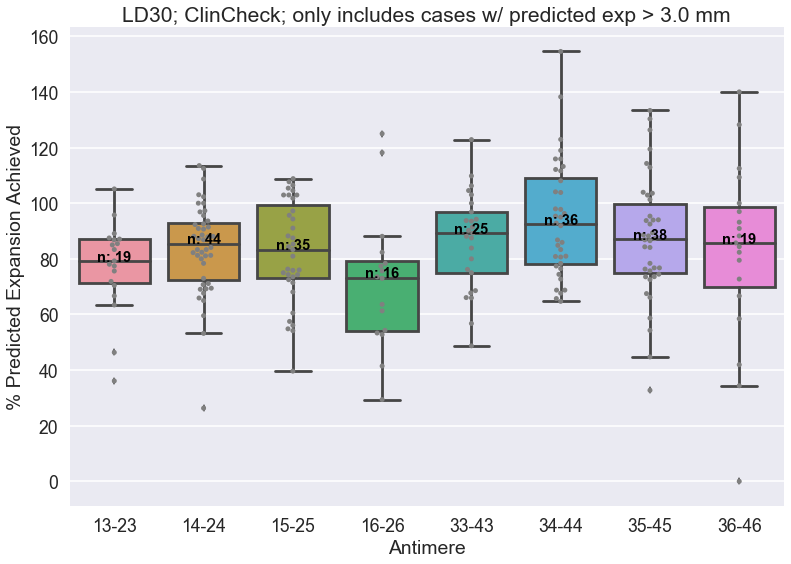

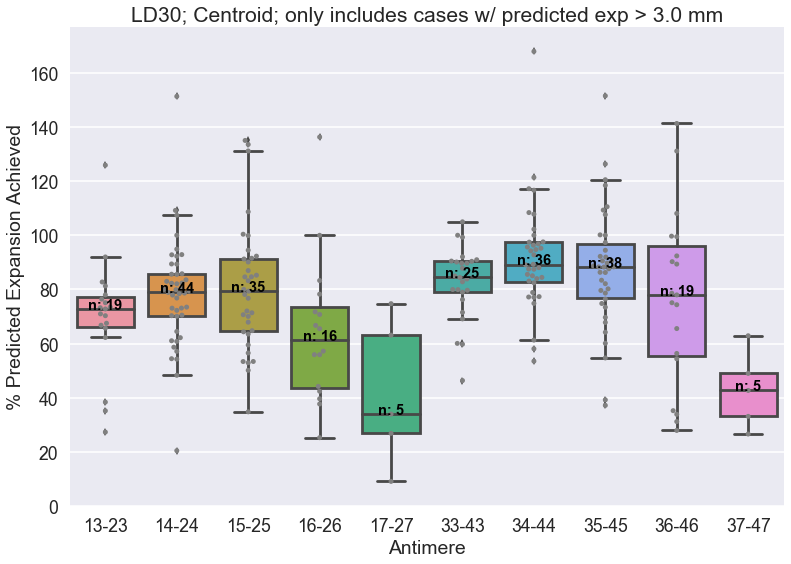

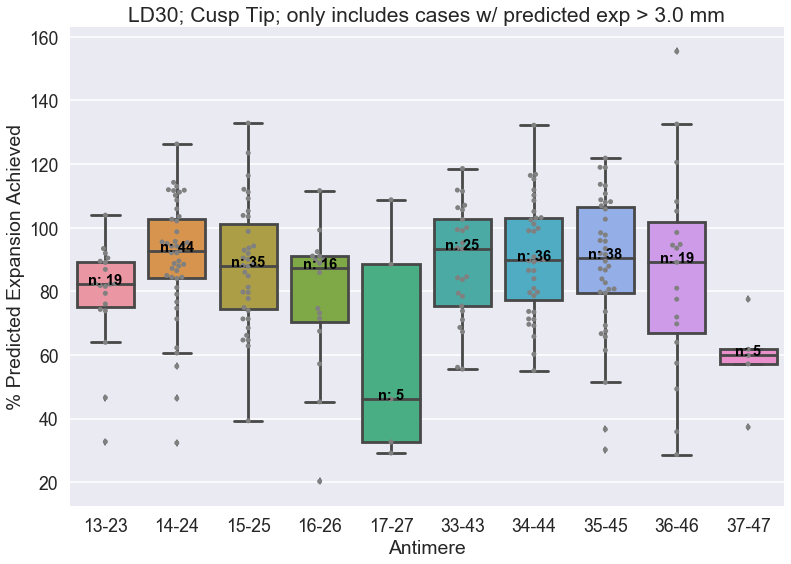

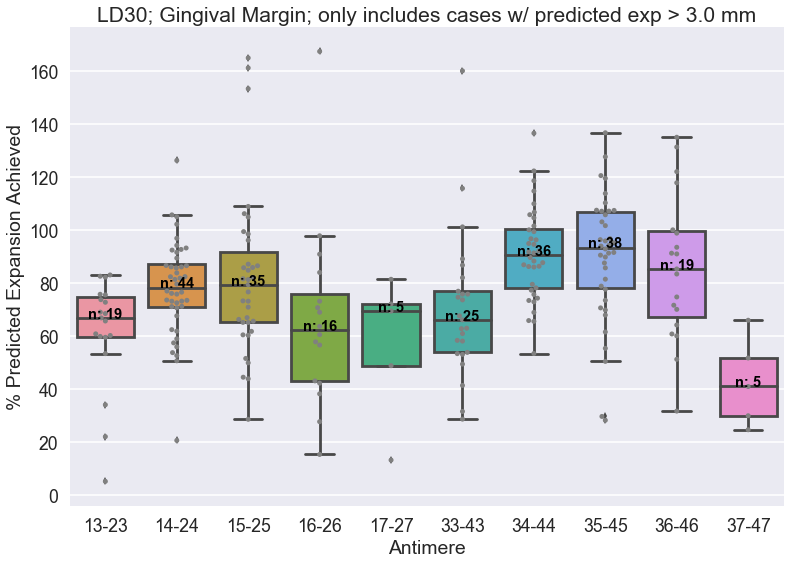

In [3]:
def boxPlot(df, measure_type, threshold, material, constant_n_obs=True):
    '''Boxplot: %Accuracy vs Antimere for a given measure_type & material.
    Only includes data where predicted exp > threshold.
    Also outputs .PDF of data.
    
    Args:
        df:
        measure_type:
        threshold:
        material:
        constant_n_obs:
            True –
                n is equal for each antimere across different measure types
                (e.g. if pt 111 has NaN value for 16-26.ctd, then will
                exclude 16-26.gm/.ct/.cc measurements)
            False – 
                includes all cases screened by other parameters (threshold)
                mainly, if NaN value exists for xx-xx.ctd, this does not impact
                whether other measure types of xx-xx are included.
    '''
    
    pp = PdfPages(os.path.join(OUTPUT_DIR, 'boxplots/boxplots-%s%s.pdf' % (material, measure_type)))
    
    sns.set('poster', font_scale=1.1)
#     sns.set_style('whitegrid', {'grid.linestyle':'--'})
#     sns.set_style('ticks', {'xtick.color':'0',
#                            'ytick.color':'0'})
    f = plt.figure()
    
    newDf = pd.DataFrame(columns = ['%acc', 'antimere', 'material'])
    
    for i, j in zip([1, 3], [2, 4]):
        for toothNum in range(3, 8):
            
            if measure_type == '.cc' and toothNum == 7:
                continue
            
            antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)
            full_antimere = '%s%s-%s%s%s %%acc' % (i, toothNum, j, toothNum, measure_type)
            
            amDf = get_antimere_df(df, antimere, full_antimere, measure_type, threshold, material, constant_n_obs)
            newDf = pd.concat([newDf, amDf], ignore_index=True)

    ax = sns.boxplot(x='antimere', y='%acc', data=newDf)
    ax = sns.swarmplot(x='antimere', y='%acc', data=newDf, color="grey")
    
    ### Adding n to boxplot.
    # Calculate number of obs & median to position labels
    medians = newDf.groupby(['antimere'])['%acc'].median().values
    nobs = newDf.groupby(['antimere'])['%acc'].count().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
    # Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
        horizontalalignment='center', size='x-small', color='k', weight='semibold')
    
    ## formatting
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    
    # Set titles
    ax.axes.set_title("%s; %s; only includes cases w/ predicted exp > %s mm" % (material, measure_type_dict[measure_type], threshold))
    ax.set_xlabel("Antimere")
    ax.set_ylabel("% Predicted Expansion Achieved")
    
    sns.plt.show()
    pp.savefig(f, bbox_inches="tight")
    pp.close()
    return

for measure_type in MEASURE_TYPES:
    boxPlot(df, measure_type, THRESHOLD, 'LD30')

In [4]:
threshold = THRESHOLD
measure_type = '.ctd'
constant_n_obs = True
material = 'LD30'
newDf = pd.DataFrame(columns = ['%acc', 'antimere', 'measure type'])

for measure_type in MEASURE_TYPES:
    for i, j in zip([1, 3], [2, 4]):
        for toothNum in range(3, 8):

            if measure_type == '.cc' and toothNum == 7:
                continue

            antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)
            full_antimere = '%s%s-%s%s%s %%acc' % (i, toothNum, j, toothNum, measure_type)

            amDf = get_antimere_df(df, antimere, full_antimere, measure_type, threshold, material, constant_n_obs)
            newDf = pd.concat([newDf, amDf], ignore_index=True)



In [5]:
medians = newDf.groupby(['antimere'])['%acc'].median().values
nobs = newDf.groupby(['antimere'])['%acc'].count().values
nobs = [str(x) for x in nobs.tolist()]

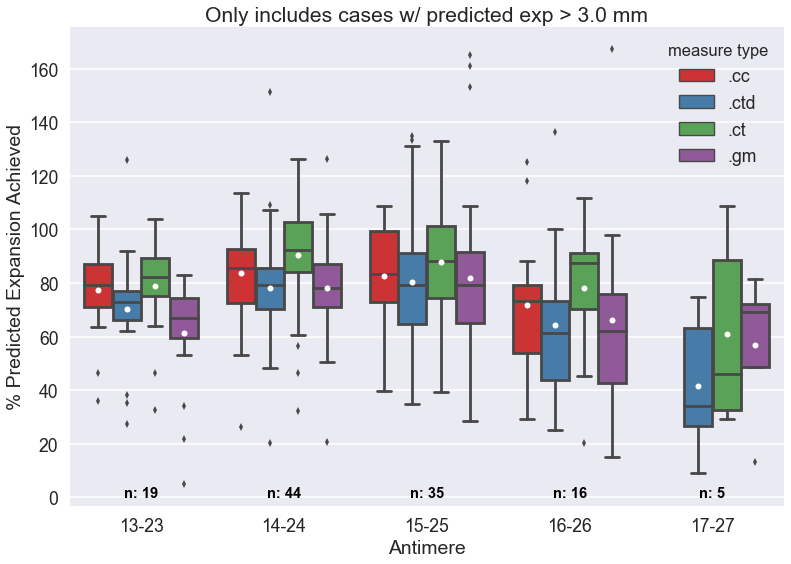

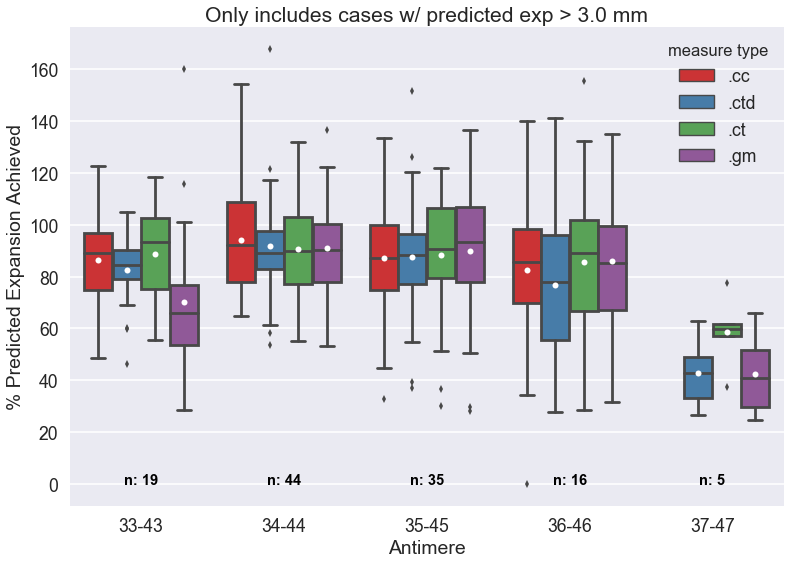

In [6]:
def multi_measures_grouped_boxplot(df, threshold, material, constant_n_obs=True):
    '''Grouped Boxplot: %Accuracy vs Antimere grouped by material (LD30 vs EX30), for a given measure_type;
    Only includes data where predicted exp > threshold.
    Also outputs .PDF of data.'''
    
    sns.set('poster', font_scale=1.1)  
    
    newDf = pd.DataFrame(columns = ['%acc', 'antimere', 'measure type'])
    
    for measure_type in MEASURE_TYPES:
        for i, j in zip([1, 3], [2, 4]):
            for toothNum in range(3, 8):

                if measure_type == '.cc' and toothNum == 7:
                    continue

                antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)
                full_antimere = '%s%s-%s%s%s %%acc' % (i, toothNum, j, toothNum, measure_type)

                amDf = get_antimere_df(df, antimere, full_antimere, measure_type, threshold, material, constant_n_obs)
                newDf = pd.concat([newDf, amDf], ignore_index=True)
                
    mxArch = ['13-23','14-24','15-25','16-26','17-27']
    mdArch = ['33-43','34-44','35-45','36-46','37-47']

    for arch in [mxArch, mdArch]:
        if arch == mxArch:
            pp = PdfPages(os.path.join(OUTPUT_DIR, 'boxplots/multi-measures-grouped-boxplots-%s-%s.pdf' % (material, 'Mx')))
        else:
            pp = PdfPages(os.path.join(OUTPUT_DIR, 'boxplots/multi-measures-grouped-boxplots-%s-%s.pdf' % (material, 'Md')))

        f = plt.figure()      
        ax = sns.boxplot(x='antimere', y='%acc', hue='measure type', data=newDf, showmeans=True, palette="Set1",
                         order=arch,
                         meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"})

        ### Adding n to boxplot.
        # Calculate number of obs & median to position labels
        medians = newDf.groupby(['antimere'])['%acc'].median().values
        nobs = newDf.groupby(['antimere'])['%acc'].count().values.tolist() # gives total n (i.e. n×4 for each measure_type or n×3 for 2nd molars)
        nMeasures = newDf.groupby(['antimere'])['measure type'].nunique().tolist()
        nobs = [str(int(x/y)) for x, y in zip(nobs, nMeasures)]
        nobs = ["n: " + i for i in nobs]
        # Add it to the plot
        pos = range(len(nobs))
        for tick,label in zip(pos,ax.get_xticklabels()):
            # ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
            # horizontalalignment='center', size='x-small', color='k', weight='semibold')
            
            ax.text(pos[tick], 0.03, nobs[tick],
            horizontalalignment='center', size='x-small', color='k', weight='semibold')
        
        ## formatting
        ax.yaxis.set_major_locator(MultipleLocator(20))
        ax.yaxis.set_minor_locator(MultipleLocator(10))
        # ax.set_ylim((-20, 200))

        # Set titles
        ax.axes.set_title("Only includes cases w/ predicted exp > %s mm" % (threshold))
        ax.set_xlabel("Antimere")
        ax.set_ylabel("% Predicted Expansion Achieved")
        sns.plt.show()

        pp.savefig(f, bbox_inches="tight")
        pp.close()

    return

multi_measures_grouped_boxplot(df, THRESHOLD, 'LD30')

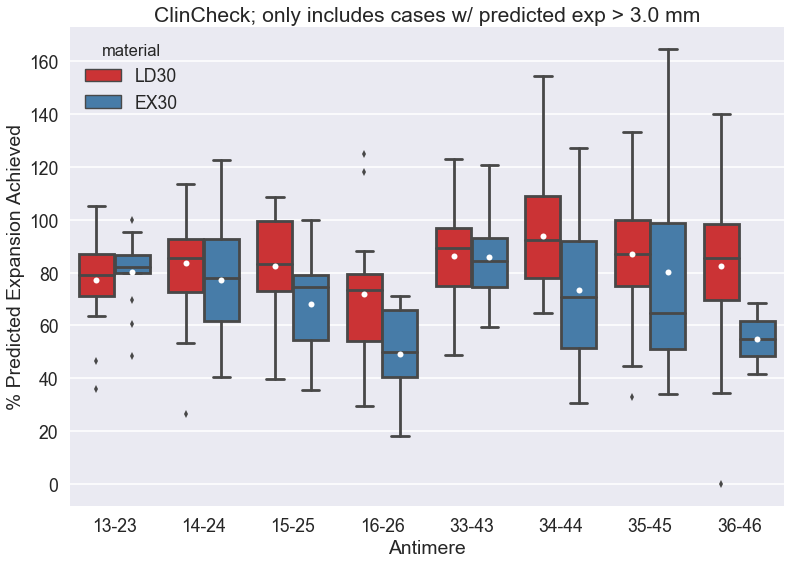

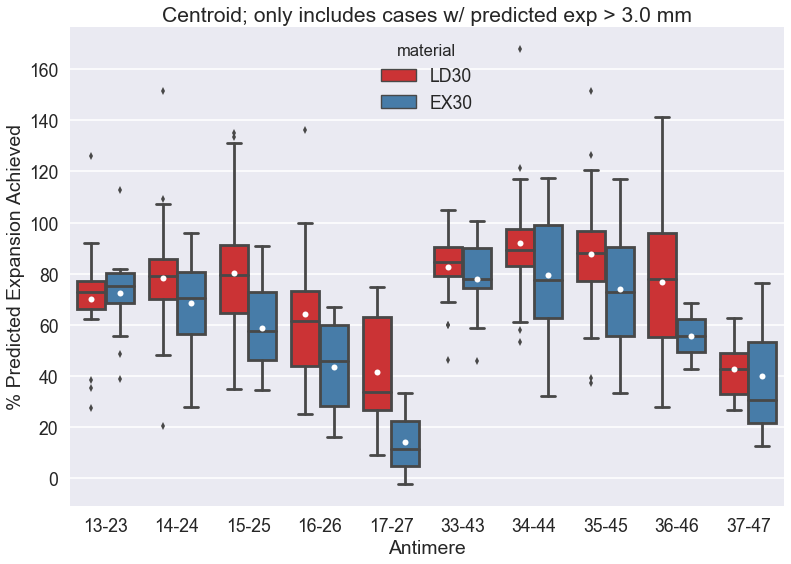

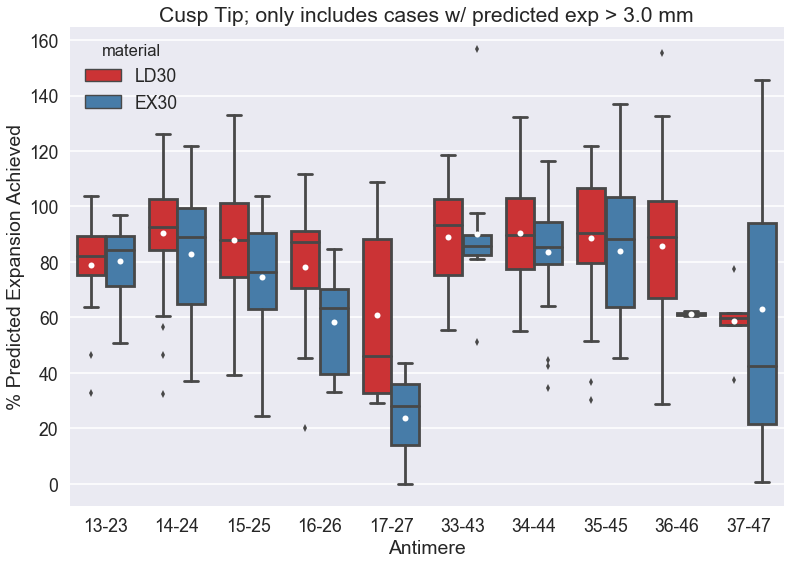

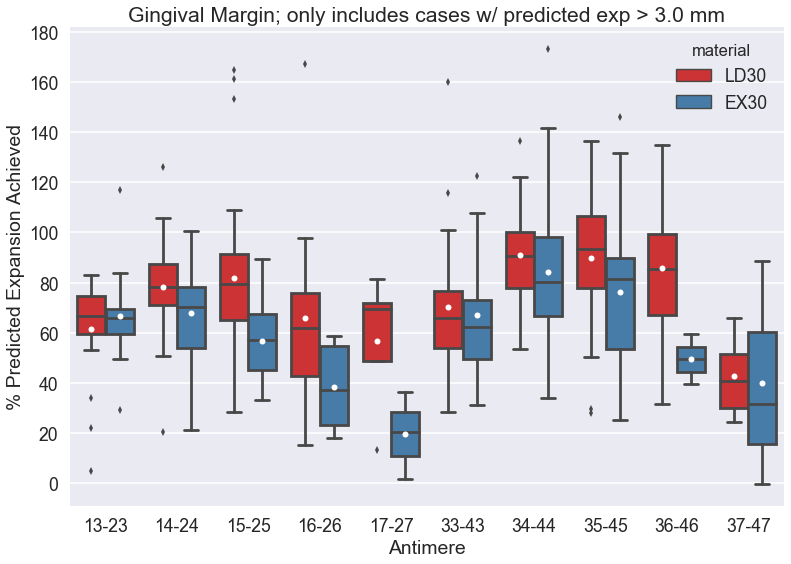

In [7]:
def LD30_vs_EX30_grouped_boxplot(df, measure_type, threshold, constant_n_obs=True):
    '''Grouped Boxplot: %Accuracy vs Antimere grouped by material (LD30 vs EX30), for a given measure_type;
    Only includes data where predicted exp > threshold.
    Also outputs .PDF of data.'''
    
    pp = PdfPages(os.path.join(OUTPUT_DIR, 'boxplots/LD30-vs-EX30-grouped-boxplots-%s.pdf' % (measure_type)))

    sns.set('poster', font_scale=1.1)

    f = plt.figure()    
    
    newDf = pd.DataFrame(columns = ['%acc', 'antimere', 'material'])
    
    for material in ['LD30', 'EX30']:
        for i, j in zip([1, 3], [2, 4]):
            for toothNum in range(3, 8):
                
                if measure_type == '.cc' and toothNum == 7:
                    continue
                
                antimere = '%s%s-%s%s' % (i, toothNum, j, toothNum)
                full_antimere = '%s%s-%s%s%s %%acc' % (i, toothNum, j, toothNum, measure_type)

                amDf = get_antimere_df(df, antimere, full_antimere, measure_type, threshold, material, constant_n_obs)
                newDf = pd.concat([newDf, amDf], ignore_index=True)
    
    ax = sns.boxplot(x='antimere', y='%acc', hue='material', data=newDf, showmeans=True, palette="Set1", 
                     meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"})

    ## formatting
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    # ax.set_ylim((-20, 200))
    
    # Set titles
    ax.axes.set_title("%s; only includes cases w/ predicted exp > %s mm" % (measure_type_dict[measure_type], threshold))
    ax.set_xlabel("Antimere")
    ax.set_ylabel("% Predicted Expansion Achieved")
    sns.plt.show()
    
    pp.savefig(f, bbox_inches="tight")
    pp.close()
    
    return
for measure_type in MEASURE_TYPES:
    LD30_vs_EX30_grouped_boxplot(df, measure_type, THRESHOLD)